--- Selected Dataset: AWEKAS (Raw) ---
Path: D:\Development\RESEARCH\neve_ilan_station\AWEKAS\Neve_Ilan_AWEKAS_20251027_20251218.csv
Data Loaded Successfully.
Time Range: 2025-10-27 00:00:00 to 2025-12-18 09:00:00
Total Records: 1258
------------------------------
Generating Synoptic Overview Plot...


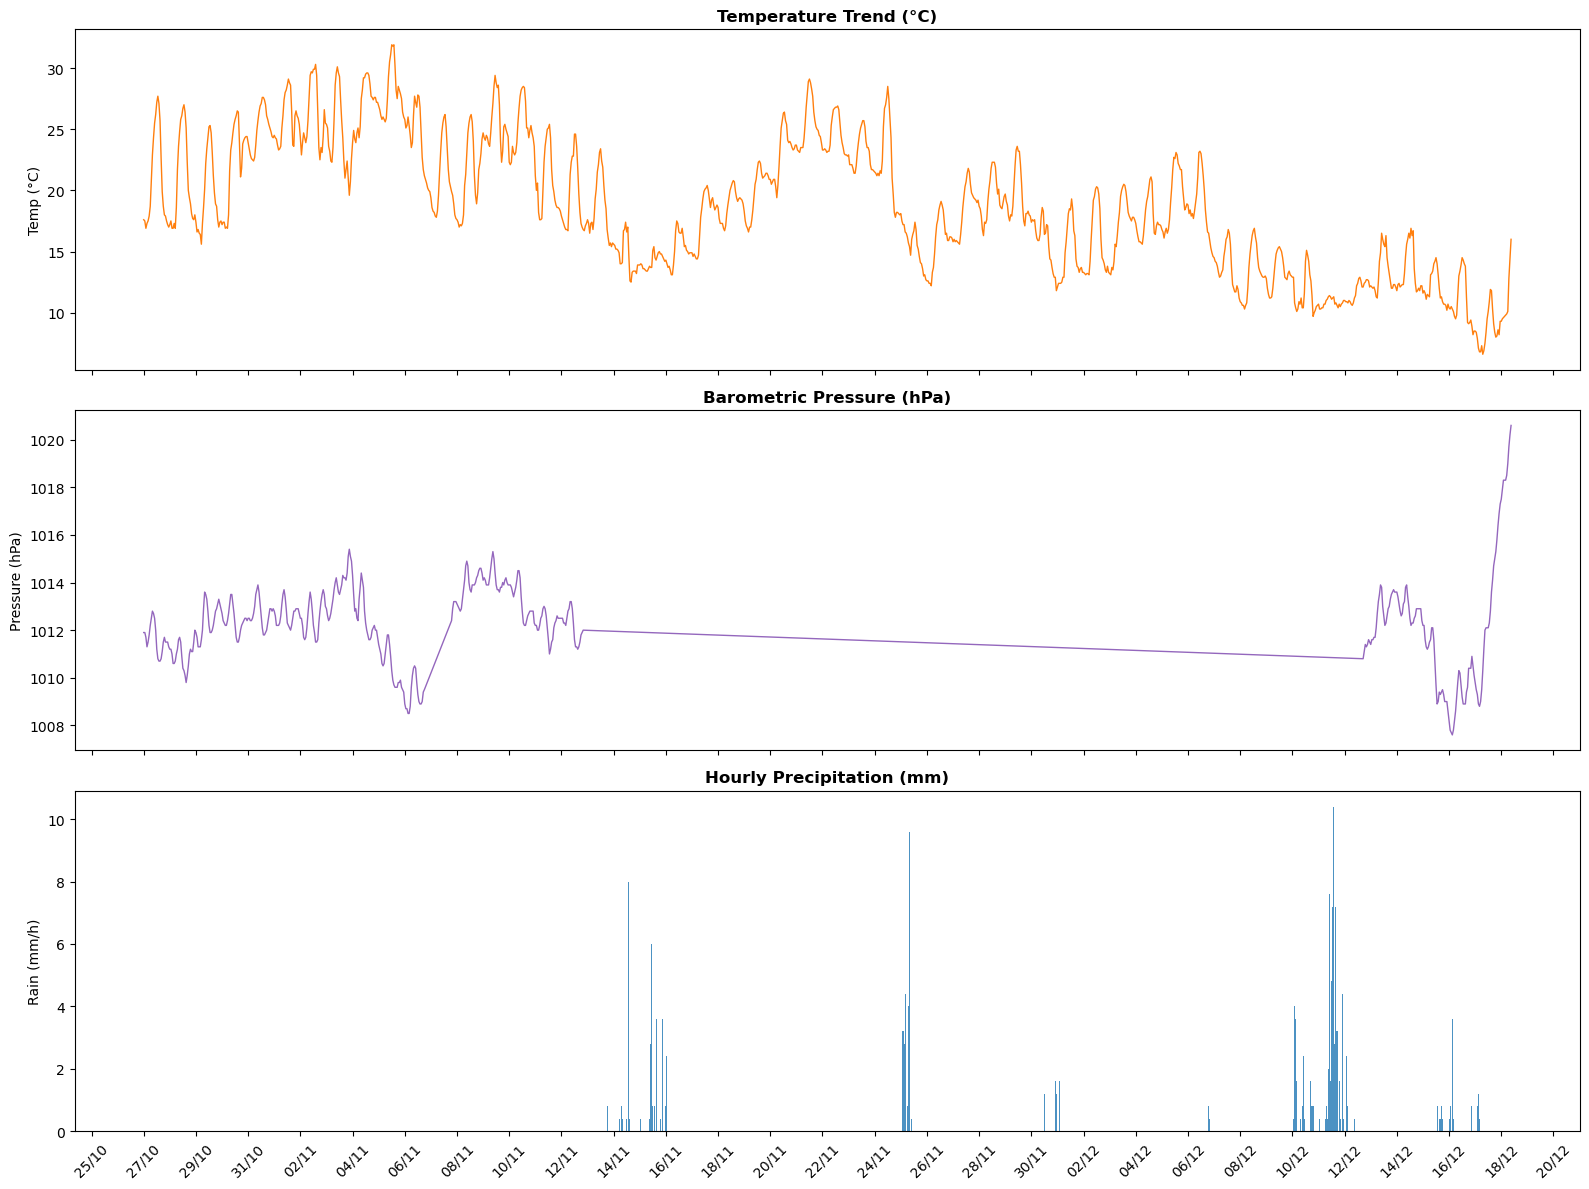

Generating Hydrological Analysis...


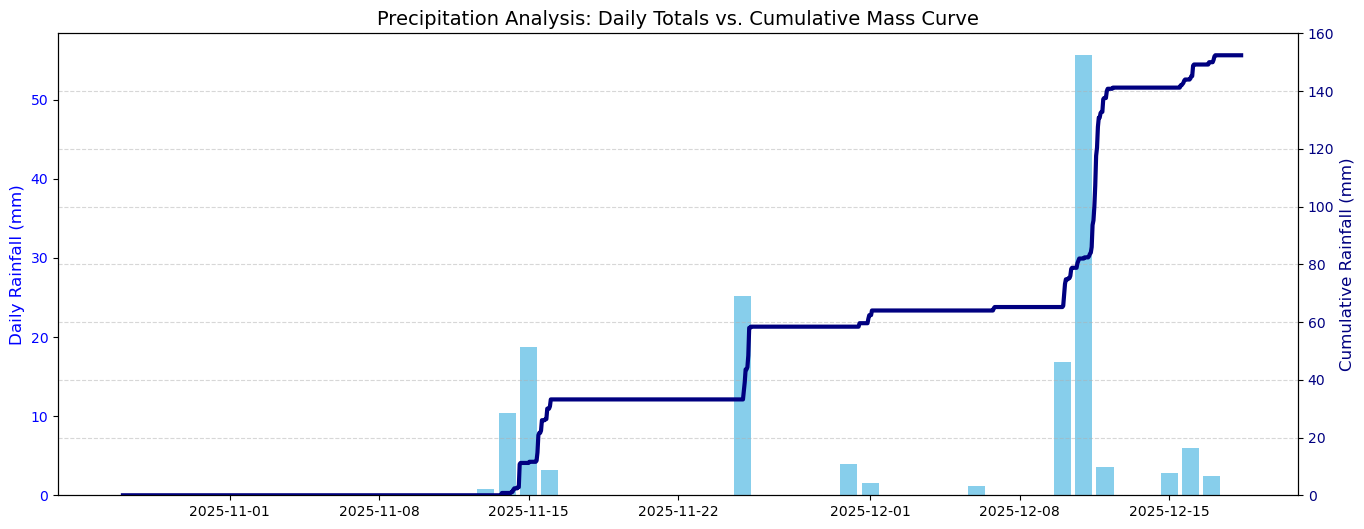


--- 🌧️ Hydrological Summary ---
Total Rainfall: 152.40 mm
Wettest Day: 11/12/2025 (55.60 mm)
Max 5-min Intensity: 10.40 mm (Recorded at 2025-12-11 14:00:00)

--- 🌡️ Temperature Summary ---
Minimum Temperature: 6.60 °C (Recorded at 2025-12-17 07:00:00)
Maximum Temperature: 31.90 °C (Recorded at 2025-11-05 12:00:00)
------------------------------
Generating Correlation Matrix...


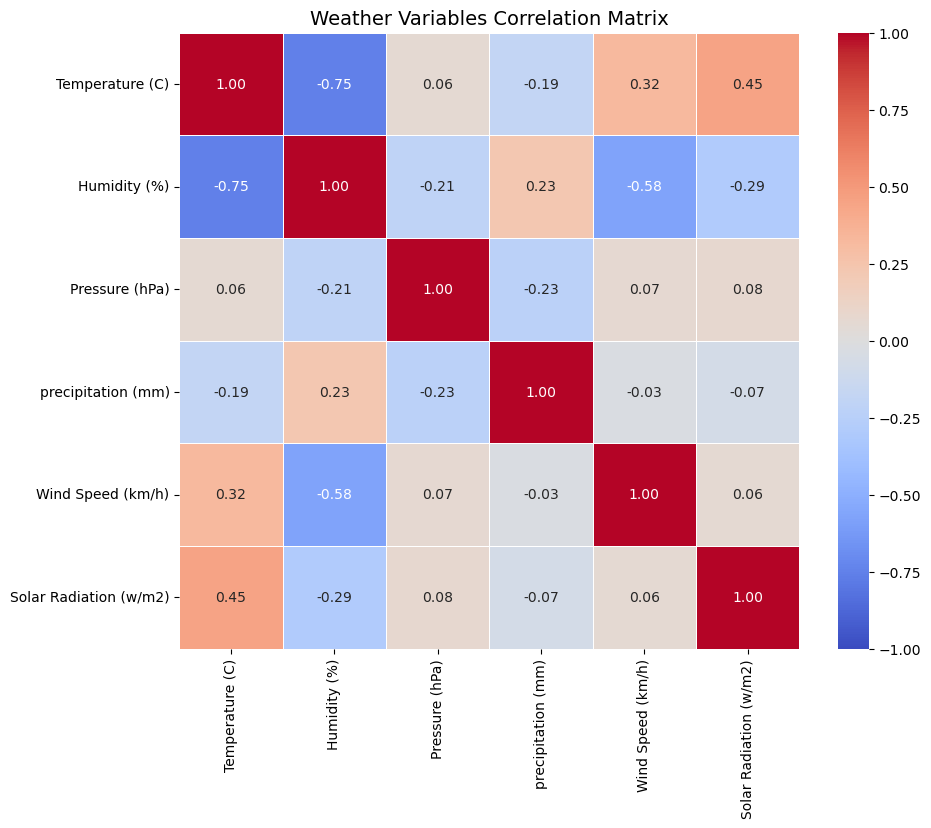

Generating Diurnal Cycle Plot...


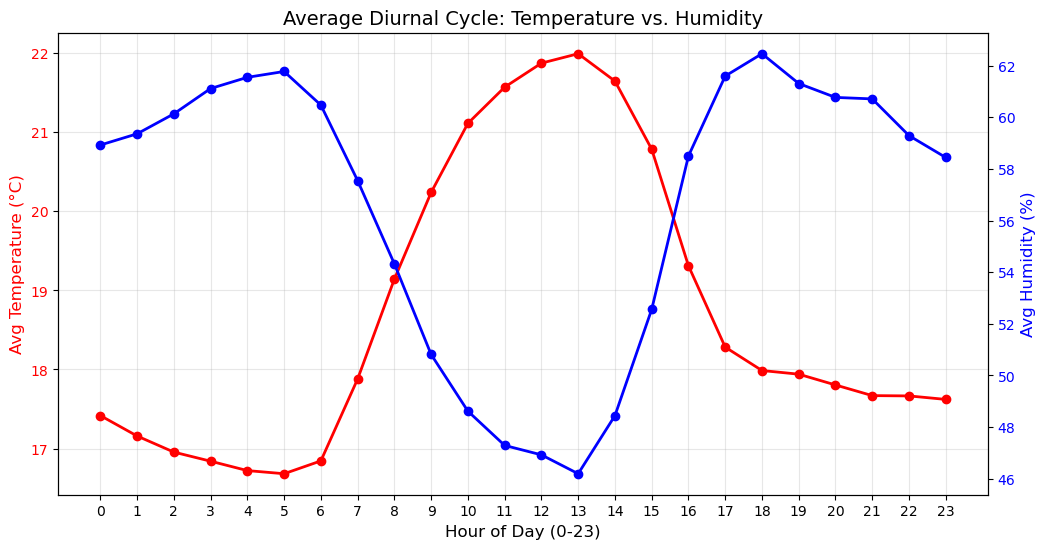

--- Analysis Complete ---


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# --- 1. CONFIGURATION: DATASET SELECTION ---

# Define the paths to your 3 datasets
base_dir = r"D:\Development\RESEARCH\neve_ilan_station"

datasets = {
    1: "WUG (Raw)",       
    2: "AWEKAS (Raw)",    
    3: "Unified (Final)"  
}

paths = {
    1: os.path.join(base_dir, "WUG", "Neve_Ilan_WUG_20251026_20251218.csv"),
    2: os.path.join(base_dir, "AWEKAS", "Neve_Ilan_AWEKAS_20251027_20251218.csv"),
    3: os.path.join(base_dir, "Unified_Complete_Weather.csv")
}

# ==========================================
# 👉 CHOOSE YOUR DATASET HERE (1, 2, or 3)
SELECTION = 2
# ==========================================

file_path = paths.get(SELECTION)
dataset_name = datasets.get(SELECTION)

print(f"--- Selected Dataset: {dataset_name} ---")
print(f"Path: {file_path}")

if not os.path.exists(file_path):
    print(f"❌ CRITICAL ERROR: File not found!\nCheck the path: {file_path}")
    raise FileNotFoundError("Selected file does not exist.")

# --- 2. DATA LOADING & PREPROCESSING ---
try:
    df = pd.read_csv(file_path)
    
    # Create Datetime Index
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('Datetime', inplace=True)
    
    # Drop redundant columns
    df.drop(columns=['Date', 'Time'], inplace=True, errors='ignore')
    
    # Ensure all analysis columns are numeric
    numeric_cols = ['Temperature (C)', 'Humidity (%)', 'Pressure (hPa)', 
                    'precipitation (mm)', 'Wind Speed (km/h)', 'Solar Radiation (w/m2)']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
    print(f"Data Loaded Successfully.")
    print(f"Time Range: {df.index.min()} to {df.index.max()}")
    print(f"Total Records: {len(df)}")
    print("-" * 30)

except Exception as e:
    print(f"Error during loading: {e}")
    exit()

# --- 3. VISUALIZATION: SYNOPTIC OVERVIEW ---
print("Generating Synoptic Overview Plot...")
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot A: Temperature
sns.lineplot(data=df, x=df.index, y='Temperature (C)', ax=axes[0], color='#ff7f0e', linewidth=1)
axes[0].set_title('Temperature Trend (°C)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temp (°C)')

# Plot B: Pressure
sns.lineplot(data=df, x=df.index, y='Pressure (hPa)', ax=axes[1], color='#9467bd', linewidth=1)
axes[1].set_title('Barometric Pressure (hPa)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Pressure (hPa)')

# Plot C: Precipitation (Hourly Sum)
hourly_rain = df['precipitation (mm)'].resample('H').sum()
axes[2].bar(hourly_rain.index, hourly_rain.values, width=0.04, color='#1f77b4', alpha=0.8)
axes[2].set_title('Hourly Precipitation (mm)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Rain (mm/h)')

axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axes[2].xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 4. HYDROLOGICAL & TEMPERATURE ANALYSIS ---
print("Generating Hydrological Analysis...")

# Calculate Daily Stats
daily_stats = df.resample('D').agg({
    'precipitation (mm)': 'sum',
    'Temperature (C)': ['max', 'min', 'mean']
})
daily_stats.columns = ['Rain_Total', 'Temp_Max', 'Temp_Min', 'Temp_Avg']

# Calculate Cumulative Rain
df['Rain_Cumulative'] = df['precipitation (mm)'].cumsum()

# Plot Daily vs Cumulative
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.bar(daily_stats.index, daily_stats['Rain_Total'], color='skyblue', label='Daily Rain', width=0.8)
ax1.set_ylabel('Daily Rainfall (mm)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0)

ax2 = ax1.twinx()
ax2.plot(df.index, df['Rain_Cumulative'], color='navy', linewidth=3, label='Cumulative Rain')
ax2.set_ylabel('Cumulative Rainfall (mm)', color='navy', fontsize=12)
ax2.tick_params(axis='y', labelcolor='navy')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylim(0)

plt.title('Precipitation Analysis: Daily Totals vs. Cumulative Mass Curve', fontsize=14)
plt.show()

# Key Statistical Calculations
total_rain = df['precipitation (mm)'].sum()
max_intensity_5min = df['precipitation (mm)'].max()
time_max_intensity = df['precipitation (mm)'].idxmax()
wettest_day_val = daily_stats['Rain_Total'].max()
wettest_day_date = daily_stats['Rain_Total'].idxmax()

# Temperature Extremes
min_temp_val = df['Temperature (C)'].min()
min_temp_time = df['Temperature (C)'].idxmin()
max_temp_val = df['Temperature (C)'].max()
max_temp_time = df['Temperature (C)'].idxmax()

print(f"\n--- 🌧️ Hydrological Summary ---")
print(f"Total Rainfall: {total_rain:.2f} mm")
print(f"Wettest Day: {wettest_day_date.strftime('%d/%m/%Y')} ({wettest_day_val:.2f} mm)")
print(f"Max 5-min Intensity: {max_intensity_5min:.2f} mm (Recorded at {time_max_intensity})")

print(f"\n--- 🌡️ Temperature Summary ---")
print(f"Minimum Temperature: {min_temp_val:.2f} °C (Recorded at {min_temp_time})")
print(f"Maximum Temperature: {max_temp_val:.2f} °C (Recorded at {max_temp_time})")
print("-" * 30)

# --- 5. CORRELATION MATRIX ---
print("Generating Correlation Matrix...")
corr_cols = ['Temperature (C)', 'Humidity (%)', 'Pressure (hPa)', 
             'precipitation (mm)', 'Wind Speed (km/h)', 'Solar Radiation (w/m2)']

existing_cols = [c for c in corr_cols if c in df.columns]
corr_matrix = df[existing_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Weather Variables Correlation Matrix', fontsize=14)
plt.show()

# --- 6. DIURNAL CYCLE (Average Day) ---
print("Generating Diurnal Cycle Plot...")
hourly_avg = df.groupby(df.index.hour).mean(numeric_only=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Temp
ax1.plot(hourly_avg.index, hourly_avg['Temperature (C)'], 'r-o', linewidth=2, label='Temperature')
ax1.set_xlabel('Hour of Day (0-23)', fontsize=12)
ax1.set_ylabel('Avg Temperature (°C)', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3)

# Humidity
ax2 = ax1.twinx()
ax2.plot(hourly_avg.index, hourly_avg['Humidity (%)'], 'b-o', linewidth=2, label='Humidity')
ax2.set_ylabel('Avg Humidity (%)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Average Diurnal Cycle: Temperature vs. Humidity', fontsize=14)
plt.show()

print("--- Analysis Complete ---")

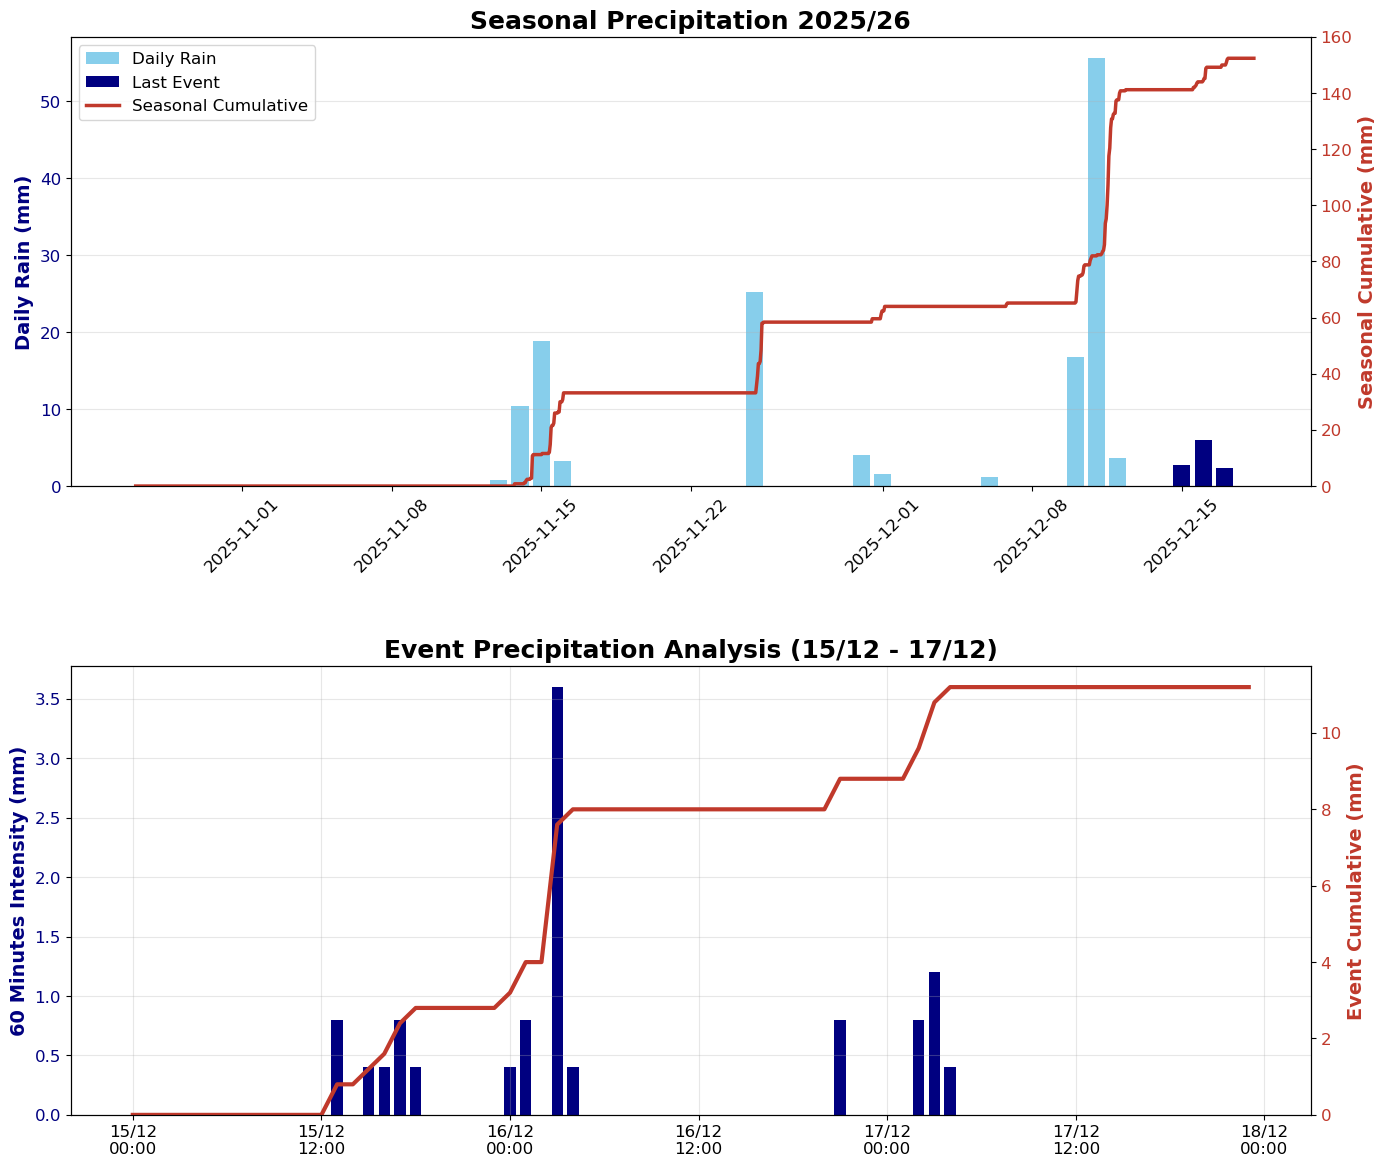

Analysis for event: 15/12 - 17/12
Total accumulation: 11.20 mm


In [2]:
# --- Rain Analysis: Seasonal & Event Focus (Final Version) ---

# 1. Prepare daily data
daily_rain = df['precipitation (mm)'].resample('D').sum()
daily_rain = daily_rain.to_frame(name='rain')
daily_rain['is_rainy'] = daily_rain['rain'] > 0

# Calculate seasonal cumulative rain for the top plot
daily_cumulative = df['precipitation (mm)'].cumsum()

# 2. Identify the last continuous rain event
daily_rain['group'] = (daily_rain['is_rainy'] != daily_rain['is_rainy'].shift()).cumsum()
rain_groups = daily_rain[daily_rain['is_rainy']]

if rain_groups.empty:
    print("No rainy days found.")
else:
    # Extract last event data
    last_event_id = rain_groups['group'].iloc[-1]
    last_event_days = rain_groups[rain_groups['group'] == last_event_id]
    
    # Define start/end times
    start_date = last_event_days.index.min().replace(hour=0, minute=0, second=0)
    end_date = last_event_days.index.max().replace(hour=23, minute=59, second=59)
    
    # Slice high-res data for the event
    event_df = df.loc[start_date:end_date].copy()
    
    # --- VISUALIZATION SETUP ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.4) # Space between plots
    
    # Define colors
    BAR_COLOR_REGULAR = 'skyblue'
    BAR_COLOR_EVENT = 'navy'  # Dark blue for the event
    LINE_COLOR_CUMULATIVE = '#C0392B' # Dark Red
    
    # --- PLOT 1: SEASONAL OVERVIEW ---
    
    # A. Daily Bars
    ax1.bar(daily_rain.index, daily_rain['rain'], color=BAR_COLOR_REGULAR, label='Daily Rain')
    # Highlight last event in Dark Blue
    ax1.bar(last_event_days.index, last_event_days['rain'], color=BAR_COLOR_EVENT, label='Last Event')
    
    # Formatting Left Y-Axis (Daily)
    ax1.set_ylabel('Daily Rain (mm)', fontsize=14, fontweight='bold', color='navy')
    ax1.tick_params(axis='y', labelsize=12, labelcolor='navy')
    ax1.set_ylim(bottom=0)  # Force start at 0
    
    # Formatting X-Axis (Date Format DD/MM)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax1.tick_params(axis='x', labelsize=12, rotation=45)
    
    # B. Seasonal Cumulative Line (Right Axis)
    ax1_twin = ax1.twinx()
    ax1_twin.plot(daily_cumulative.index, daily_cumulative, color=LINE_COLOR_CUMULATIVE, linewidth=2.5, label='Seasonal Cumulative')
    
    # Formatting Right Y-Axis (Cumulative)
    ax1_twin.set_ylabel('Seasonal Cumulative (mm)', fontsize=14, fontweight='bold', color=LINE_COLOR_CUMULATIVE)
    ax1_twin.tick_params(axis='y', labelsize=12, labelcolor=LINE_COLOR_CUMULATIVE)
    ax1_twin.set_ylim(bottom=0) # Force start at 0
    
    # Title & Legend
    ax1.set_title('Seasonal Precipitation 2025/26', fontsize=18, fontweight='bold')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)
    
    ax1.grid(axis='y', alpha=0.3)

    # --- PLOT 2: EVENT ZOOM ---
    
    # Prepare Event Data
    event_hourly = event_df['precipitation (mm)'].resample('H').sum()
    event_cum_curve = event_df['precipitation (mm)'].cumsum()
    event_cum_curve = event_cum_curve - event_cum_curve.iloc[0] # Start from 0
    
    # A. Hourly Bars
    ax2.bar(event_hourly.index, event_hourly.values, width=0.03, color=BAR_COLOR_EVENT, label='60 Min Intensity')
    
    # Formatting Left Y-Axis (Changed to "60 Minutes Intensity")
    ax2.set_ylabel('60 Minutes Intensity (mm)', fontsize=14, fontweight='bold', color=BAR_COLOR_EVENT)
    ax2.tick_params(axis='y', labelsize=12, labelcolor=BAR_COLOR_EVENT)
    ax2.tick_params(axis='x', labelsize=12, rotation=0)
    ax2.set_ylim(bottom=0) # Force start at 0
    
    # B. Event Cumulative Line (Right Axis)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(event_df.index, event_cum_curve, color=LINE_COLOR_CUMULATIVE, linewidth=3, label='Event Cumulative')
    
    # Formatting Right Y-Axis
    ax2_twin.set_ylabel('Event Cumulative (mm)', fontsize=14, fontweight='bold', color=LINE_COLOR_CUMULATIVE)
    ax2_twin.tick_params(axis='y', labelsize=12, labelcolor=LINE_COLOR_CUMULATIVE)
    ax2_twin.set_ylim(bottom=0) # Force start at 0
    
    # Title & Formatting
    event_start_str = start_date.strftime("%d/%m")
    event_end_str = end_date.strftime("%d/%m")
    ax2.set_title(f'Event Precipitation Analysis ({event_start_str} - {event_end_str})', fontsize=18, fontweight='bold')
    
    # X-Axis Date Format
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m\n%H:%M'))
    ax2.grid(True, alpha=0.3)
    
    plt.show()

    # --- SUMMARY ---
    print(f"Analysis for event: {event_start_str} - {event_end_str}")
    print(f"Total accumulation: {event_df['precipitation (mm)'].sum():.2f} mm")

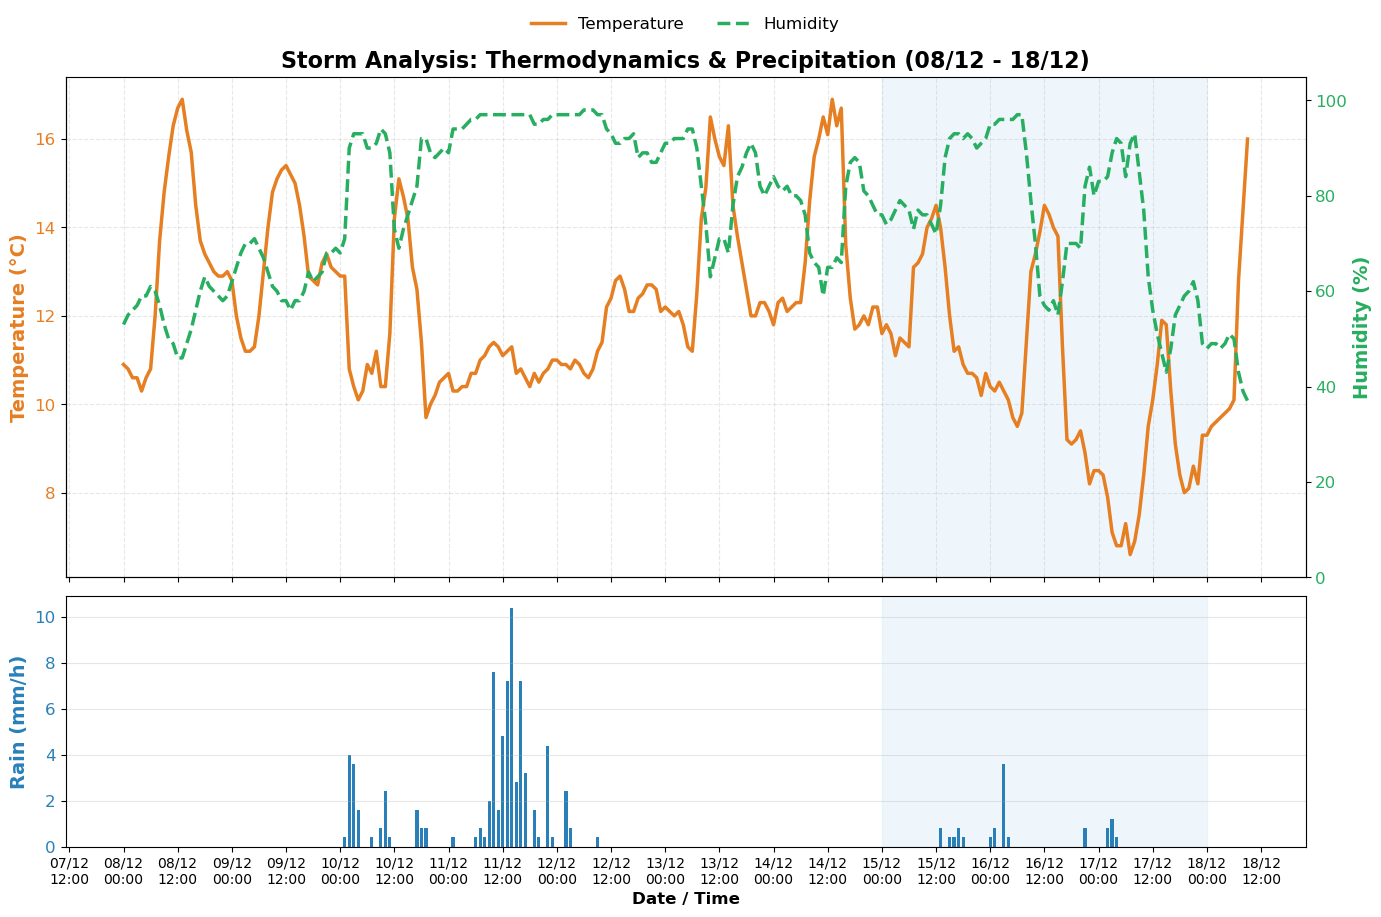

       TEMPERATURE ANALYSIS
Avg Temp (Full Window):  11.88 °C
Avg Temp (Pre-Event):    12.51 °C
Avg Temp (During Event): 10.52 °C
--------------------
Temp Difference:         -1.99 °C


In [3]:
# --- Complete Analysis: Temp, Humidity & Rain Context (-6 Days / +1 Day) ---

# 1. Define the Expanded Time Window
# Subtract 6 days from start, Add 1 day to end
window_start = start_date - pd.Timedelta(days=7)
window_end = end_date + pd.Timedelta(days=1)

# Slice the dataframe for this extended period
df_window = df.loc[window_start:window_end].copy()

# Resample rain to hourly for clear bars
window_hourly_rain = df_window['precipitation (mm)'].resample('H').sum()

if df_window.empty:
    print("Error: No data found for the requested time window.")
else:
    # --- VISUALIZATION SETUP ---
    # Create 2 subplots sharing the X-axis. 
    # height_ratios=[2, 1] means the top plot is twice as tall as the rain plot
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, 
                                            gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
    
    # Define Colors
    COLOR_TEMP = '#E67E22'      # Burnt Orange
    COLOR_HUMIDITY = '#27AE60'  # Green
    COLOR_RAIN = '#2980B9'      # Blue
    COLOR_EVENT_BG = '#D6EAF8'  # Light background for event context

    # --- TOP PANEL: Temperature & Humidity ---
    
    # 1. Temperature (Left Axis)
    ax_top.plot(df_window.index, df_window['Temperature (C)'], color=COLOR_TEMP, linewidth=2.5, label='Temperature')
    ax_top.set_ylabel('Temperature (°C)', fontsize=14, fontweight='bold', color=COLOR_TEMP)
    ax_top.tick_params(axis='y', labelsize=12, labelcolor=COLOR_TEMP)
    ax_top.grid(True, linestyle='--', alpha=0.3)
    
    # 2. Humidity (Right Axis)
    ax_top_twin = ax_top.twinx()
    ax_top_twin.plot(df_window.index, df_window['Humidity (%)'], color=COLOR_HUMIDITY, linewidth=2.5, linestyle='--', label='Humidity')
    ax_top_twin.set_ylabel('Humidity (%)', fontsize=14, fontweight='bold', color=COLOR_HUMIDITY)
    ax_top_twin.tick_params(axis='y', labelsize=12, labelcolor=COLOR_HUMIDITY)
    ax_top_twin.spines['top'].set_visible(False)
    ax_top_twin.set_ylim(0, 105) # Keep logical humidity range

    # Highlight Event Duration (Top Panel)
    ax_top.axvspan(start_date, end_date, color=COLOR_EVENT_BG, alpha=0.4, zorder=0)

    # --- BOTTOM PANEL: Precipitation ---
    
    # Rain Bars
    ax_bottom.bar(window_hourly_rain.index, window_hourly_rain.values, width=0.03, color=COLOR_RAIN, label='Rain (Hourly)')
    ax_bottom.set_ylabel('Rain (mm/h)', fontsize=14, fontweight='bold', color=COLOR_RAIN)
    ax_bottom.tick_params(axis='y', labelsize=12, labelcolor=COLOR_RAIN)
    ax_bottom.grid(True, axis='y', alpha=0.3)
    ax_bottom.set_ylim(bottom=0) # Start from 0

    # Highlight Event Duration (Bottom Panel)
    ax_bottom.axvspan(start_date, end_date, color=COLOR_EVENT_BG, alpha=0.4, zorder=0)

    # --- COMMON FORMATTING ---
    
    # Title (on top plot)
    title_start = window_start.strftime("%d/%m")
    title_end = window_end.strftime("%d/%m")
    ax_top.set_title(f'Storm Analysis: Thermodynamics & Precipitation ({title_start} - {title_end})', fontsize=16, fontweight='bold')
    
    # Legend (Top Panel - Combined)
    lines_1, labels_1 = ax_top.get_legend_handles_labels()
    lines_2, labels_2 = ax_top_twin.get_legend_handles_labels()
    ax_top.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', 
                  bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False, fontsize=12)

    # X-Axis Formatting (Bottom Panel only)
    ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m\n%H:%M'))
    ax_bottom.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    ax_bottom.set_xlabel('Date / Time', fontsize=12, fontweight='bold')

    plt.show()

    # --- TEMPERATURE STATISTICS ---
    
    # 1. Average for the whole displayed window
    avg_temp_total = df_window['Temperature (C)'].mean()

    # 2. Average BEFORE the event (within the displayed window)
    # Filter data from window_start up to start_date
    pre_event_data = df_window.loc[:start_date]
    avg_temp_pre = pre_event_data['Temperature (C)'].mean()

    # 3. Average DURING the event
    # Filter data specifically between start_date and end_date
    event_data = df_window.loc[start_date:end_date]
    avg_temp_event = event_data['Temperature (C)'].mean()

    # --- PRINT SUMMARY ---
    print(f"="*40)
    print(f"       TEMPERATURE ANALYSIS")
    print(f"="*40)
    print(f"Avg Temp (Full Window):  {avg_temp_total:.2f} °C")
    print(f"Avg Temp (Pre-Event):    {avg_temp_pre:.2f} °C")
    print(f"Avg Temp (During Event): {avg_temp_event:.2f} °C")
    print("-" * 20)
    # Calculate the drop in temperature
    temp_diff = avg_temp_event - avg_temp_pre
    print(f"Temp Difference:         {temp_diff:.2f} °C")
    print(f"="*40)